# Shift example

A visualization to explain the mechanic of shifting for in-frame uAUG, to detect lengthenings of the canonical protein

In [1]:
# Must restart the kernel for this
from deepexplain.tensorflow import DeepExplain
#from deeplift.dinuc_shuffle import dinuc_shuffle, traverse_edges, shuffle_edges, prepare_edges
from collections import Counter

from importlib import reload
import re
import random
from pathlib import Path
random.seed(1337)
import os
import pickle
from decimal import Decimal

import numpy as np
np.random.seed(1337)
import pandas as pd
pd.options.mode.chained_assignment = None 
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib_config
import seaborn as sns

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping

import utils_data
import model

Using TensorFlow backend.


In [2]:
from bpnet.cli.contrib import ContribFile
from bpnet.plot.tracks import plot_tracks, to_neg
from concise.utils.plot import seqlogo

Instructions for updating:
Colocations handled automatically by placer.


2021-02-18 11:47:26,423 [WARNING] From /opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


# Shift Example

build dataframe

In [3]:
utr = "GTCACCTGGAAGGCCGGGAGCCCCTGCTCATCGCGATCCTCTCCTTGTAC"
utr_snv = "GTCACCTGGAAGGCCGGGAGCCCCTGCTCATCGCGATGCTCTCCTTGTAC"
utr_shift = "GTCACCTGGAAGGCCGGGAGCCCCTGCTCATCGCGATCCTCTCCTTGTACN"
utr_snv_shift = "GTCACCTGGAAGGCCGGGAGCCCCTGCTCATCGCGATGCTCTCCTTGTACN"

In [4]:
df = pd.DataFrame({"utr": [utr, utr_snv, utr_shift, utr_snv_shift]})

In [5]:
# Encoding functions
one_hot_fn = utils_data.OneHotEncoder("utr")
library_fn = utils_data.LibraryEncoder("library", {"egfp_unmod_1":0, "random":1})

generator = utils_data.DataSequence(df, encoding_functions=[one_hot_fn], 
                                    output_encoding_fn=None, shuffle=True)

In [6]:
utr_model = load_model("../Models/utr_model_50.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer})

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2021-02-18 11:47:39,160 [WARNING] From /opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.cast instead.


2021-02-18 11:48:00,094 [WARNING] From /opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


2021-02-18 11:48:00,239 [WARNING] From /opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [7]:
pred = utr_model.predict_generator(generator)

In [8]:
pred

array([[7.189123 ],
       [7.453937 ],
       [6.1232915],
       [3.888638 ]], dtype=float32)

In [9]:
effect_1 = np.log2(pred[1]/pred[0])
effect_2 = np.log2(pred[3]/pred[2])

In [10]:
effect_1

array([0.05218676], dtype=float32)

In [11]:
effect_2

array([-0.6550425], dtype=float32)

Visualization

In [12]:
encoded_df = one_hot_fn(df)

In [13]:
def explain_deeply(encoded_df, batchsize=64):
    K.clear_session()
    sess = K.get_session()
    with DeepExplain(session=sess) as de:
        utr_model = load_model("../Models/utr_model_50.h5", 
                   custom_objects={'FrameSliceLayer': model.FrameSliceLayer})
        input_tensor = utr_model.layers[0].input
        target_tensor = utr_model(input_tensor)
        return de.explain('occlusion', target_tensor, input_tensor, encoded_df, batch_size=batchsize)

In [14]:
def plot_logo(arr, name="", fig_dims = (6.0, 1.5)):
    fig,ax = plt.subplots()
    seqlogo(arr, vocab="RNA", ax=ax)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_ylim(-1.75, 1.75)
    #ax.set_ylabel("")
    #ax.tick_params(axis='both', which='major', labelsize=10)

    sns.despine(fig, bottom=True, left=True)
    fig.set_size_inches(fig_dims)
    fig.savefig(Path("../Graphics/Shift/" + name +".svg"))

In [15]:
attrib = explain_deeply(encoded_df)

2021-02-18 11:48:59,499 [INFO] DeepExplain: running "occlusion" explanation method (6)
2021-02-18 11:48:59,508 [INFO] Model with multiple inputs: False
2021-02-18 11:48:59,513 [INFO] Input shape: [None, 4]; window_shape (1, 1); step 1


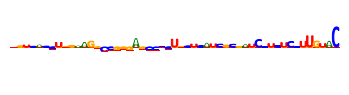

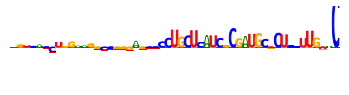

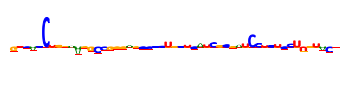

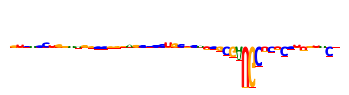

In [16]:
for i in range(4):
    plot_logo(attrib[i], name="contrib_shift_0" + str(i))

# Indel Example

In [18]:
utr = "GTCACCTGGAAGGCCGGGAGCCCCTGCTCATCCCGATCCTCTCCTTGTAC"
utr_snv = "GTCACCTGGAATGGCCGGGAGCCCCTGCTCATCCCGATCCTCTCCTTGTAC"

df = pd.DataFrame({"utr": [utr, utr_snv, utr_snv_shift]})

# Encoding functions
one_hot_fn = utils_data.OneHotEncoder("utr")
library_fn = utils_data.LibraryEncoder("library", {"egfp_unmod_1":0, "random":1})

generator = utils_data.DataSequence(df, encoding_functions=[one_hot_fn], 
                                    output_encoding_fn=None, shuffle=True)

utr_model = load_model("../Models/utr_model_50.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer})

pred = utr_model.predict_generator(generator)

effect = np.log2(pred[1]/pred[0])

print(effect)

[-0.682583]


In [19]:
encoded_df = one_hot_fn(df)
attrib = explain_deeply(encoded_df)

2021-02-12 11:08:57,008 [INFO] DeepExplain: running "occlusion" explanation method (6)
2021-02-12 11:08:57,017 [INFO] Model with multiple inputs: False
2021-02-12 11:08:57,021 [INFO] Input shape: [None, 4]; window_shape (1, 1); step 1


In [24]:
def plot_logo(arr, name="", fig_dims = (6.0, 1.5)):
    fig,ax = plt.subplots()
    seqlogo(arr, vocab="RNA", ax=ax)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_ylim(-2.5, 2.25)
    #ax.set_ylabel("")
    #ax.tick_params(axis='both', which='major', labelsize=10)

    sns.despine(fig, bottom=True, left=True)
    fig.set_size_inches(fig_dims)
    fig.savefig(Path("../Graphics/Shift/" + name +".svg"))

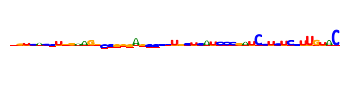

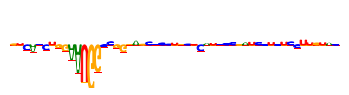

In [25]:
for i in range(2):
    plot_logo(attrib[i], name="contrib_indel_" + str(i))

In [4]:
utr = "GTCACCTGGAAGGCCGGGAGCCCCTGCTCATCCCGATCCTCTCCTTGTAC"
utr_snv = "GTCACCTGGAAGGCCGGGAGCCCCTGCTCATCCCGATCCTCTGTCCCCCCTTGTAC"

df = pd.DataFrame({"utr": [utr, utr_snv]})

# Encoding functions
one_hot_fn = utils_data.OneHotEncoder("utr")
library_fn = utils_data.LibraryEncoder("library", {"egfp_unmod_1":0, "random":1})

generator = utils_data.DataSequence(df, encoding_functions=[one_hot_fn], 
                                    output_encoding_fn=None, shuffle=True)

utr_model = load_model("../Models/utr_model_50.h5", custom_objects={'FrameSliceLayer': model.FrameSliceLayer})

pred = utr_model.predict_generator(generator)

effect = np.log2(pred[1]/pred[0])

print(effect)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2021-02-13 16:21:21,639 [WARNING] From /opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.cast instead.


2021-02-13 16:21:23,605 [WARNING] From /opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


2021-02-13 16:21:23,681 [WARNING] From /opt/modules/i12g/anaconda/3-2018.12/envs/5utrclone/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:102: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


[-0.19877319]


In [5]:
pred

array([[7.260539 ],
       [6.3260436]], dtype=float32)

In [28]:
encoded_df = one_hot_fn(df)
attrib = explain_deeply(encoded_df)

2021-02-12 11:24:55,232 [INFO] DeepExplain: running "occlusion" explanation method (6)
2021-02-12 11:24:55,241 [INFO] Model with multiple inputs: False
2021-02-12 11:24:55,245 [INFO] Input shape: [None, 4]; window_shape (1, 1); step 1


In [30]:
def plot_logo(arr, name="", fig_dims = (6.0, 1.5)):
    fig,ax = plt.subplots()
    seqlogo(arr, vocab="RNA", ax=ax)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_ylim(-1.5, 1.5)
    #ax.set_ylabel("")
    #ax.tick_params(axis='both', which='major', labelsize=10)

    sns.despine(fig, bottom=True, left=True)
    fig.set_size_inches(fig_dims)
    fig.savefig(Path("../Graphics/Shift/" + name +".svg"))

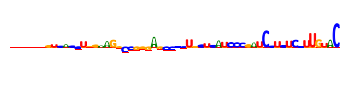

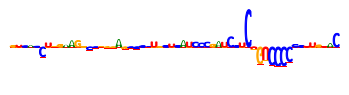

In [31]:
for i in range(2):
    plot_logo(attrib[i], name="contrib_indel_gucccc_" + str(i))